Noteboook de maintenance

# Import des bib

In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# import des données

In [228]:
data=pd.read_csv('Dataframe1.csv')

In [229]:
data=data.drop(['index','index.1','customer_id.1','index.2','order_id.1','index.3','order_id.2',
                'index.4','order_id.3','index.5','product_id.1','index.6', 'product_category_name.1'],axis=1).reset_index()

In [230]:
data= data.drop(['order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date','product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm','review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp','customer_id','product_id','order_item_id','seller_id','review_id',],axis=1)

In [231]:
data=data.dropna()

In [232]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96490 entries, 0 to 99439
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   index                          96490 non-null  int64  
 1   customer_unique_id             96490 non-null  object 
 2   customer_zip_code_prefix       96490 non-null  int64  
 3   customer_city                  96490 non-null  object 
 4   customer_state                 96490 non-null  object 
 5   order_id                       96490 non-null  object 
 6   order_status                   96490 non-null  object 
 7   order_purchase_timestamp       96490 non-null  object 
 8   shipping_limit_date            96490 non-null  object 
 9   price                          96490 non-null  float64
 10  freight_value                  96490 non-null  float64
 11  payment_sequential             96490 non-null  float64
 12  payment_type                   96490 non-null 

# Calcul de RFM

In [233]:
def calculate_rfm(data, reference_date):
    # Convertir la colonne 'order_purchase_timestamp' en format datetime si ce n'est pas déjà fait
    if 'order_purchase_timestamp' in data.columns:
        data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])
    data_before_reference = data[data['order_purchase_timestamp'] < reference_date]
    # Calculer la récence pour chaque client
    recency = (data_before_reference.groupby(by='customer_unique_id')['order_purchase_timestamp'].max().pipe(lambda x: (data_before_reference['order_purchase_timestamp'].max() - x).dt.days))
    # Calculer le nombre d'achats (fréquence) pour chaque client
    frequency = data_before_reference.groupby('customer_unique_id')['order_purchase_timestamp'].count()

    # Calculer le montant total dépensé (monetary) par chaque client
    monetary = data_before_reference.groupby('customer_unique_id')['payment_value'].sum()

    rfm = pd.DataFrame({'Recency': recency, 'Frequency': frequency, 'Monetary': monetary})
    return rfm

In [234]:
#rfm0 = calculate_rfm(data)
rfm1 = calculate_rfm(data, datetime(2018, 1, 14))

In [235]:
rfm1

,Recency,Frequency,Monetary
customer_unique_id,,,
0000f46a3911fa3c0805444483337064,309,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,93,1,43.62
0004aac84e0df4da2b147fca70cf8255,60,1,196.89
0005e1862207bf6ccc02e4228effd9a0,315,1,150.12
0006fdc98a402fceb4eb0ee528f6a8d4,179,1,29.00
...,...,...,...
fffb09418989a0dbff854a28163e47c6,27,1,73.16
fffcf5a5ff07b0908bd4e2dbc735a684,219,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,34,1,84.58


In [236]:
def calculate_scaler_and_kmeans(rfm_data):
    # StandardScaler sur les données RFM
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm_data)
    # Utilisation de KMeans pour trouver les clusters
    kmeans = KMeans(n_clusters=4, random_state=42) 
    kmeans.fit(rfm_scaled)
    return scaler, kmeans

In [237]:
print("Dernier date", data.order_purchase_timestamp.max())
print("Premier date", data.order_purchase_timestamp.min())

Dernier date 2018-09-03 09:06:57
Premier date 2016-09-04 21:15:19


# Calcul de ARI

In [238]:
def calculate_ari_over_time(data):
    # Initialisation des variables pour stocker les résultats
    ari_values = []
    dates = []

    # Calculer le RFM initial
    end_date =  datetime(2018, 1, 1) 
    rfm0 = calculate_rfm(data, end_date)
    scaler0, kmeans0 = calculate_scaler_and_kmeans(rfm0)

    # Calculer l'ARI pour chaque intervalle de 15 jours
    interval = timedelta(days=14)
    #end_date =  datetime(2017, 11, 17) 

    while end_date <= data['order_purchase_timestamp'].max():
        # Calculer RFM pour cet intervalle
        rfm = calculate_rfm(data, end_date)
        
        # Appliquer StandardScaler0 sur rfm
        rfm_scaled_0 = scaler0.transform(rfm)
        
        # Prédire les clusters de rfm en utilisant les centroids de KMeans0
        L0 = kmeans0.predict(rfm_scaled_0)
        
        # Calculer StandardScaler et KMeans pour rfm
        scaler, kmeans = calculate_scaler_and_kmeans(rfm)
        
        # Appliquer StandardScaler sur rfm
        rfm_scaled = scaler.transform(rfm)
        
        # Prédire les clusters de rfm en utilisant les centroids de KMeans
        L1 = kmeans.predict(rfm_scaled)
        
        # Calculer l'Adjusted Rand Index (ARI) entre L10 et L11
        ari = adjusted_rand_score(L0, L1)
        
        # Stocker les résultats
        ari_values.append(ari)
        dates.append(end_date)
        
        # Mettre à jour la date de fin pour le prochain intervalle
        end_date += interval

    # Créer une série temporelle des valeurs ARI
    ari_series = pd.Series(ari_values, index=dates)
    
    return ari_series

# Appeler la fonction pour calculer l'ARI sur chaque intervalle de 15 jours
ari_over_time = calculate_ari_over_time(data)

# Afficher les résultats
print(ari_over_time)

2018-01-01    1.000000
2018-01-15    0.952001
2018-01-29    0.909421
2018-02-12    0.863895
2018-02-26    0.797921
2018-03-12    0.766580
2018-03-26    0.726289
2018-04-09    0.700916
2018-04-23    0.654939
2018-05-07    0.531167
2018-05-21    0.483137
2018-06-04    0.508096
2018-06-18    0.424684
2018-07-02    0.373206
2018-07-16    0.329044
2018-07-30    0.303881
2018-08-13    0.401170
2018-08-27    0.381310
dtype: float64


# Graphe

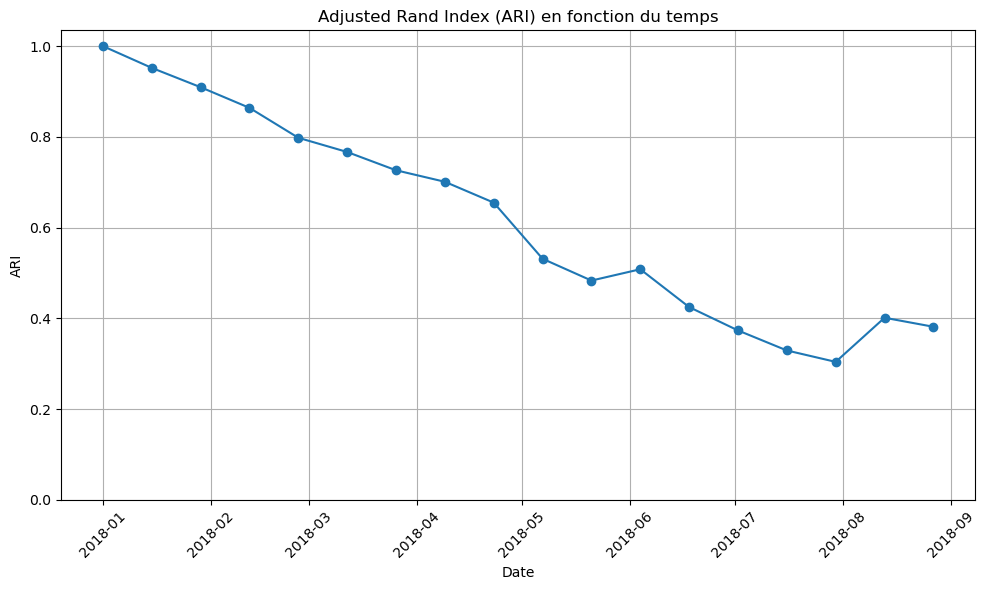

In [241]:
ari_over_time = calculate_ari_over_time(data)

# Tracer le graphique de l'ARI en fonction du temps avec un pas de 0.3 dans l'axe y
plt.figure(figsize=(10, 6))
plt.plot(ari_over_time.index, ari_over_time.values, marker='o', linestyle='-')
plt.title("Adjusted Rand Index (ARI) en fonction du temps")
plt.xlabel("Date")
plt.ylabel("ARI")
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(np.arange(0, max(ari_over_time) + 0.2, 0.2))  
plt.tight_layout()
plt.show()

Une observation significative est la stabilité du score ARI pendant les deux premiers mois, suivie d'une diminution. Cela suggère que la maintenance devrait être effectuée tous les deux mois.

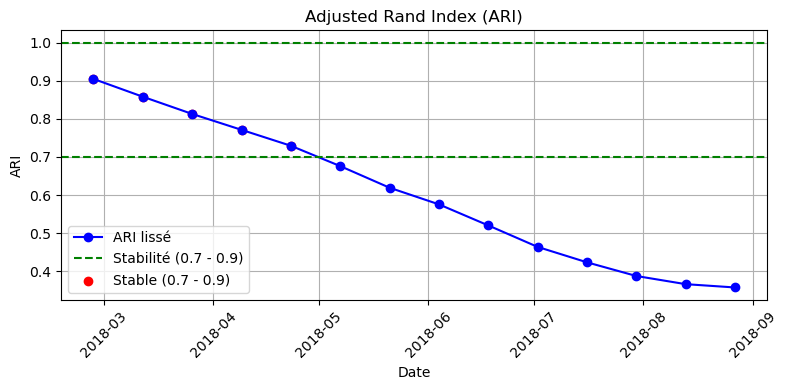

In [239]:
def smooth_data(data, window_size):
    return data.rolling(window=window_size).mean()

# Fonction pour tracer l'ARI lissé avec des périodes de stabilité entre 0.7 et 0.9
def plot_smoothed_ari_with_stability(data, stability_range, window_size):
    # Calculer l'ARI lissé
    ari_over_time = calculate_ari_over_time(data)
    smoothed_ari = smooth_data(ari_over_time, window_size)
    
    # Tracer le graphique de l'ARI lissé
    plt.figure(figsize=(8, 4))
    plt.plot(smoothed_ari.index, smoothed_ari.values, color='blue', linestyle='-', marker='o', label='ARI lissé')
    
    # Tracer une ligne horizontale pour la plage de stabilité
    plt.axhline(y=stability_range[0], color='green', linestyle='--', label='Stabilité (0.7 - 0.9)')
    plt.axhline(y=stability_range[1], color='green', linestyle='--')
    
    # Marquer les périodes de stabilité dans la plage spécifiée
    stable_periods = smoothed_ari[(smoothed_ari >= stability_range[0]) & (smoothed_ari <= stability_range[1])]
    plt.scatter(stable_periods.index, stable_periods.values, color='red', label='Stable (0.7 - 0.9)')
    
    plt.title("Adjusted Rand Index (ARI)")
    plt.xlabel("Date")
    plt.ylabel("ARI")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Paramètres
stability_range = (0.7, 1)  # Plage de stabilité entre 0.7 et 0.9
window_size = 5  # Taille de la fenêtre pour le lissage

# Appeler la fonction pour tracer l'ARI lissé avec des périodes de stabilité
plot_smoothed_ari_with_stability(data, stability_range, window_size)